In [1]:
from environment.models import SinusoidalControlledFixedEnv

import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import tensorflow as tf
from collections import namedtuple


2024-07-16 12:34:19.981801: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-16 12:34:20.051201: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Hyperparameters

In [2]:
# Hyperparameters
# ENV LATENCY
ENV_LATENCY = 200
# Parameters
N_EPISODES = 400                 # Number of episodes # 100 - 1000
DISCOUNT_FACTOR = 0.99            # Value of the discount factor (gamma)
N_EP_RUNNING_AVERAGE = 5         # Running average of episodes
N_ACTIONS = 4                     # Number of available actions (nr of angles)
DIM_STATE = 2                     # State dimensionality
REPLAY_SIZE = 30000                # 5000 - 30000
BATCH_SIZE = 4                   # 4 - 128
CRITIC_LR = 0.002                  # Critic learning rate 1e-2 - 1e-3
ACTOR_LR = 0.001                  # Actor learning rate 1e-3 - 1e-4
TARGET_REWARD = 0               # to stop the training
MAX_ENV_STEPS = 1000              # to stop the episode # one minute increments
TAU = 0.005                       # Used to update target networks # 0.001 - 0.005
POLICY_UPDATE_FREQ = 2           # Frequency of updating the policy

# We will use these variables to compute the average episodic reward and
# the average number of steps per episode
episode_reward_list = []       # this list contains the total reward per episode
episode_number_of_steps = []   # this list contains the number of steps per episode

# NOTES
TRAINING_NOTE = "onlyZ nsinus actorNN_with_leakyReLu"


### Noise model hyperparameters

In [3]:
# Noise Model Hyperparameters
STD_DEV = 0.4
#* NOTE: MEAN = (A_UPPER_BOUND + A_LOWER_BOUND) / 2

# Environment Definition & Testing

In [4]:
env = SinusoidalControlledFixedEnv(sinusoidal_components=1, seed=1337)
env.delta_t = 0.1
# print(env.delta_t)
# env.max_t = 2
# env.delta_t = 0.01
env.fixed_error_ctrl_pump = [0, 0, 0, 0]
env.fixed_error_ctrl_alice = [np.pi, 0, 0, 0]
env.fixed_error_ctrl_bob = [0, 0, 0, 0]
env.fixed_errors_flags = [True, True, True, True, 
                          False, True, True, True, 
                          True, True, True, True]
env.latency = ENV_LATENCY
env.max_t = MAX_ENV_STEPS*env.delta_t
env.setting_inverse = True

# ENV SPECIFIC
A_UPPER_BOUND = 1.0
A_LOWER_BOUND = -1.0

### Test output

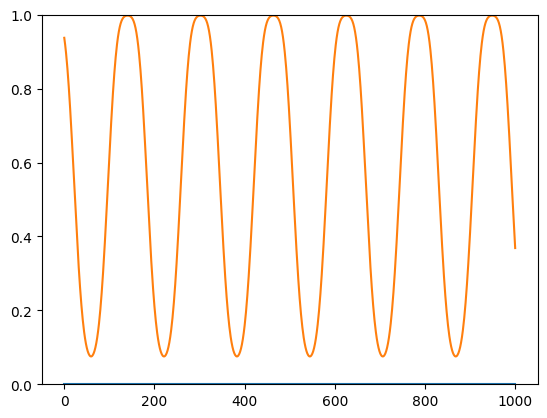

In [5]:
state = env.reset()
done = False
baseline_reward = 0
while not done:
    state, reward, done = env.step()
    baseline_reward += reward
    if done:
        break

plt.figure()
plt.ylim(0, 1)
plt.plot(env.qber_history)

# Agents definition

In [6]:
class Agent(object):
    ''' Base agent class, used as a parent class

        Args:
            n_actions (int): number of actions

        Attributes:
            n_actions (int): where we store the number of actions
            last_action (np.array): last action taken by the agent
    '''
    def __init__(self, n_actions: int):
        self.n_actions = n_actions
        self.last_action = None

    def forward(self, state: np.ndarray):
        ''' Performs a forward computation '''
        pass

    def backward(self):
        ''' Performs a backward pass on the network '''
        pass

In [7]:
class RandomAgent(Agent):
    ''' Agent taking actions uniformly at random, child of the class Agent'''
    def __init__(self, n_actions: int):
        super(RandomAgent, self).__init__(n_actions)

    def forward(self, state: np.ndarray) -> int:
        ''' Compute an action uniformly at random across n_actions possible
            choices

            Returns:
                action np.array(int): the random action for each angle
        '''
        action = []
        for i in range(self.n_actions):
            action.append(np.random.randint(-2*np.pi, 2*np.pi))
        self.last_action = np.array(action)
        return self.last_action

# Define Buffer

Create a class for the experience replay buffer

In [8]:
Experience = namedtuple('Experience',
                        ['state', 'action', 'reward', 'next_state', 'done'])
class ExperienceReplayBuffer:
    """ Class used to store a buffer containing experiences of the RL agent.
    """
    def __init__(self, buffer_capacity=100000, batch_size=64, critic_model=None, actor_model=None, target_actor=None, target_critic=None, critic_optimizer=None, actor_optimizer=None):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, DIM_STATE)) 
        self.action_buffer = np.zeros((self.buffer_capacity, N_ACTIONS)) 
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, DIM_STATE)) 
        
        # pass the models to the buffer
        self.critic_model = critic_model
        self.actor_model = actor_model
        self.target_actor = target_actor
        self.target_critic = target_critic
        self.critic_optimizer = critic_optimizer
        self.actor_optimizer = actor_optimizer

    # Takes (s,a,r,s') observation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1
        
    # sample a batch from the buffer
    def sample(self, batch_size):
        record_range = min(self.buffer_counter, self.buffer_capacity)
        batch_indices = np.random.choice(record_range, batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype="float32")
        next_state_batch = tf.convert_to_tensor(
            self.next_state_buffer[batch_indices]
        )

        return state_batch, action_batch, reward_batch, next_state_batch
    
    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self,
        state_batch,
        action_batch,
        reward_batch,
        next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        
        # step 11:
        # update critic
        with tf.GradientTape() as tape:
            target_actions = self.target_actor(next_state_batch, training=True)
            # print([next_state_batch, target_actions])
            y = reward_batch + DISCOUNT_FACTOR * self.target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = self.critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.reduce_mean(tf.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, self.critic_model.trainable_variables)
        self.critic_optimizer.apply_gradients(
            zip(critic_grad, self.critic_model.trainable_variables)
        )

        # step 13:
        # update actor
        if self.buffer_counter % POLICY_UPDATE_FREQ == 0:
            with tf.GradientTape() as tape:
                actions = self.actor_model(state_batch, training=True)
                critic_value = self.critic_model([state_batch, actions], training=True)
                # Used `-value` as we want to maximize the value given
                # by the critic for our actions
                actor_loss = -tf.reduce_mean(critic_value)

            actor_grad = tape.gradient(actor_loss, self.actor_model.trainable_variables)
            self.actor_optimizer.apply_gradients(
                zip(actor_grad, self.actor_model.trainable_variables)
            )

    # We compute the loss and update parameters
    def learn(self):
        # step 9:
        # Sample a batch of experiences from the buffer
        state_batch, action_batch, reward_batch, next_state_batch = self.sample(self.batch_size) 
        
        # steps 10-13:
        # update the actor and critic networks
        self.update(state_batch, action_batch, reward_batch, next_state_batch)
        
# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
def update_target(target, original, tau):
    target_weights = target.get_weights()
    original_weights = original.get_weights()

    for i in range(len(target_weights)):
        target_weights[i] = original_weights[i] * tau + target_weights[i] * (1 - tau)

    target.set_weights(target_weights)

# Define Noise Func

In [9]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)
            
class GaussNoise:
    def __init__(self, mean, std_deviation):
        self.mean = mean
        self.std_dev = std_deviation
    
    def __call__(self):
        return np.random.normal(self.mean, self.std_dev)
    
    def reset(self):
        pass

In [10]:
# Noise model
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(STD_DEV) * np.ones(1), theta=0.05)

gauss_noise = GaussNoise(mean=np.zeros(1) * float((A_LOWER_BOUND + A_UPPER_BOUND)/2), std_deviation=float(STD_DEV) * np.ones(1))

# Define Actor and Critic Networks

In [11]:
from keras.regularizers import l2
from keras import layers

def get_actor(num_states: int, num_actions: int, upper_bound: float):
    # Initialize weights between -3e-3 and 3-e3
    last_init = keras.initializers.RandomUniform(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(512, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    # out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    out = layers.Dense(256, activation="relu")(out)
    # out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    out = layers.Dense(32, activation="relu")(out)
    # out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    outputs = layers.Dense(num_actions, activation="tanh", kernel_initializer=last_init)(out)

    outputs = outputs * upper_bound
    model = keras.Model(inputs, outputs)
    return model

def get_critic(num_states: int, num_actions: int):
    state_input = layers.Input(shape=(num_states,))
    state_out = layers.Dense(64, activation="relu")(state_input)
    # state_out = layers.BatchNormalization()(state_out)
    # state_out = layers.LeakyReLU()(state_out)
    # state_out = layers.Dense(256, activation="relu")(state_out)
    # state_out = layers.BatchNormalization()(state_out)
    # state_out = layers.LeakyReLU()(state_out)

    action_input = layers.Input(shape=(num_actions,))
    action_out = layers.Dense(128, activation="relu")(action_input)
    # action_out = layers.Dense(256, activation="relu")(action_out)
    # action_out = layers.Dense(256, activation="relu")(action_out)
    action_out = layers.Dense(64, activation="relu")(action_out)
    # action_out = layers.BatchNormalization()(action_out)
    # action_out = layers.LeakyReLU()(action_out)

    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    # # out = layers.BatchNormalization()(out)
    # # out = layers.LeakyReLU()(out)
    # out = layers.Dense(128, activation="relu")(out)
    # # out = layers.BatchNormalization()(out)
    # # out = layers.LeakyReLU()(out)
    out = layers.Dense(12, activation="relu")(out)
    # out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = keras.Model([state_input, action_input], outputs)

    return model

# Define DDPG Agent class

In [12]:
class DDPGAgent(Agent):
    def __init__(self, state_size, action_size, replay_length=5000, batch_size=64, gamma=0.99, learning_rate_critic=1e-2, learning_rate_actor=1e-3, n_episodes=800, tau=0.001, noise_model=None):
        super(DDPGAgent, self).__init__(action_size)
        
        self.learning_rate_critic = learning_rate_critic
        self.learning_rate_actor = learning_rate_actor
        self.n_episodes = n_episodes
        self.episode = 0
        self.epsilon = 1
        self.Z = 0.9*self.n_episodes
        self.epsilon_max = 0.99
        self.epsilon_min = 0.05
        self.tau = tau
        self.noise_model = noise_model
        
        # env specific
        self.min_action = A_LOWER_BOUND
        self.max_action = A_UPPER_BOUND
        
        # step 1:
        ### Create actor and critic networks
        self.actor_model = get_actor(state_size, action_size, self.max_action)
        self.critic_model = get_critic(state_size, action_size)

        self.target_actor = get_actor(state_size, action_size, self.max_action)
        self.target_critic = get_critic(state_size, action_size)

        # Making the weights equal initially
        self.target_actor.set_weights(self.actor_model.get_weights())
        self.target_critic.set_weights(self.critic_model.get_weights())

        critic_optimizer = keras.optimizers.Adam(learning_rate_critic)
        actor_optimizer = keras.optimizers.Adam(learning_rate_actor)
        
        # step 2:
        ### Create Experience replay buffer
        self.buffer = ExperienceReplayBuffer(buffer_capacity=replay_length, batch_size=batch_size, critic_model=self.critic_model, actor_model=self.actor_model, target_actor=self.target_actor, target_critic=self.target_critic, critic_optimizer=critic_optimizer, actor_optimizer=actor_optimizer)
        self.batch_size = batch_size
        self.gamma = gamma
        
        ### Agent init
        self.state_size = state_size
        self.action_size = action_size
        
        ### Steps
        self.target_update_rate = int(replay_length/batch_size) # suggested as tip
        self.steps = 0  # Counter for steps taken

    def forward(self, state):
        # step 7:
        # take noisy continuous action a_t at s_t   
        sampled_actions = tf.squeeze(self.actor_model(state))
        noise = self.noise_model()
        # Adding noise to action
        sampled_actions = sampled_actions.numpy() + noise

        # We make sure action is within bounds
        legal_action = np.clip(sampled_actions, A_LOWER_BOUND, A_UPPER_BOUND)

        # return action
        return np.squeeze(legal_action)

    def backward(self):
        if self.buffer.buffer_counter < self.batch_size:
            return
        
        # steps 8-13:
        self.buffer.learn()

        # step 12:
        if self.steps % POLICY_UPDATE_FREQ == 0:
            # step 14:
            # soft update target networks
            update_target(self.target_actor, self.actor_model, self.tau)
            update_target(self.target_critic, self.critic_model, self.tau)
        
        # step 16:
        # Increment steps counter
        self.steps += 1

## Some useful funcs

In [13]:
def running_average(x, N):
    ''' Function used to compute the running average
        of the last N elements of a vector x
    '''
    if len(x) >= N:
        y = np.copy(x)
        y[N-1:] = np.convolve(x, np.ones((N, )) / N, mode='valid')
    else:
        y = np.zeros_like(x)
    return y


def faster_running_average(x, N, last_average):
    if len(x) > N:
        return last_average + (1./N)*(x[-1] - x[-N - 1])
    else:
        return sum(x)/len(x)

# Agent initialisation

In [14]:
# agent initialization
# agent = RandomAgent(n_actions) # random
# step 1 & 2:
agent = DDPGAgent(DIM_STATE, N_ACTIONS, REPLAY_SIZE, batch_size=BATCH_SIZE, gamma=DISCOUNT_FACTOR, learning_rate_actor=ACTOR_LR, learning_rate_critic=CRITIC_LR, n_episodes=N_EPISODES, tau=TAU, noise_model=gauss_noise)

2024-07-16 12:34:21.831458: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Training

In [15]:
### Training process
from tqdm import tqdm
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Initialize tqdm loop
pbar = tqdm(range(N_EPISODES))

actual_episodes = 0

  0%|          | 0/400 [00:00<?, ?it/s]

In [16]:
best_result = {
    'qber': 0,
    'total_rewards': -100000,
    'episode': 0
}

To facilitate getting higher-quality training data, you may reduce the scale of the noise over the course of training. (We do not do this in our implementation, and keep noise scale fixed throughout.)

At test time, to see how well the policy exploits what it has learned, we do not add noise to the actions.

Our DDPG implementation uses a trick to improve exploration at the start of training. For a fixed number of steps at the beginning (set with the start_steps keyword argument), the agent takes actions which are sampled from a uniform random distribution over valid actions. After that, it returns to normal DDPG exploration.

In [17]:
import datetime

# pbar = tqdm(range(N_EPISODES))

avg_reward = 0.
avg_steps = 0.
# step 3:
# episode loop
for ep in pbar:
    # Reset environment data and initialize variables
    done = False
    # step 4:
    prev_state, _ = env.reset()
 
    total_episode_reward = 0.
    # step 5:
    t = 0
    # step 6: 
    # environment loop
    while not done:
        tf_prev_state = tf.expand_dims(
            tf.convert_to_tensor(prev_state[0]), 0
        )
        # step 7:
        # noisy actor action
        action = agent.forward(tf_prev_state)

        # step 8:
        # Execute action in the environment and append
        _a = [np.array(action[0:4]), np.zeros(4), np.zeros(4), np.zeros(4)]
        # print(_a)
        state, reward, done = env.step(a_alice=_a)
        np.fft.rfft(state[0])

        # append to buffer
        agent.buffer.record((prev_state[0], action, reward, state[0]))
        
        # step 9-15: see function definition
        agent.backward()
        
        # Update episode reward
        total_episode_reward += reward
        
        # End this episode when `done`
        if done:
            break

        # step 16: Update state for next iteration
        prev_state = state
        t += 1
        
    if total_episode_reward > best_result['total_rewards']:
        best_result = {
            'qber': env.get_qber(),
            'total_rewards': total_episode_reward,
            'episode': ep
        } 

    # Append episode reward and total number of steps
    episode_reward_list.append(total_episode_reward)
    episode_number_of_steps.append(t)

    avg_reward = faster_running_average(episode_reward_list, N_EP_RUNNING_AVERAGE, avg_reward)
    avg_steps = faster_running_average(episode_number_of_steps, N_EP_RUNNING_AVERAGE, avg_steps)

    agent.episode += 1

    # Updates the tqdm update bar with fresh information
    # (episode number, total reward of the last episode, total number of Steps
    # of the last episode, average reward, average number of steps)
    pbar.set_description(f"Episode {ep+1} Episode Reward: {total_episode_reward:.2f} Avg Reward ({N_EP_RUNNING_AVERAGE}): {avg_reward:.2f} Reward Baseline: {baseline_reward:.2f} Best: Ep {best_result['episode']} -> reward: {best_result['total_rewards']:.2f}")

    actual_episodes += 1
    
    # stop if we hit reward threshold
    if avg_reward >= TARGET_REWARD:
        break


total_training_time = pbar.format_dict['elapsed']
avg_time_per_ep = total_training_time/actual_episodes
training_completed_timestamp = datetime.datetime.now()

Episode 400 Episode Reward: -187.60 Avg Reward (5): -186.20 Reward Baseline: -343.21 Best: Ep 253 -> reward: -166.35: 100%|██████████| 400/400 [03:32<00:00,  1.88it/s]


# Save plots and data

### Save params

In [18]:
# save params in csv to avoid file name length issue
import csv

# create UID
import uuid
uid = uuid.uuid4()

# save plot params
dir = "output/"
fname = f"{uid}_E{N_EPISODES}_"
fname2= "_gamma{gamma}_tau{tau}_nactions{num_actions}_nstates{num_states}_lbound{lower_bound:.2f}_ubound{upper_bound:.2f}_latency{env.latency}_lractor{actor_lr:.4f}_lrcritic{critic_lr:.4f}_stdef{std_dev:.2f}_"+TRAINING_NOTE+".png"

# Create a list of parameter names and values
params = [
    ('uid', str(uid)),
    ('date_completed', training_completed_timestamp),
    ('total_episodes', N_EPISODES),
    ('gamma', DISCOUNT_FACTOR),
    ('tau', TAU),
    ('num_actions', N_ACTIONS),
    ('num_states', DIM_STATE),
    ('lower_bound', A_LOWER_BOUND),
    ('upper_bound', A_UPPER_BOUND),
    ('ep_running_average', N_EP_RUNNING_AVERAGE),
    ('buffer_size', REPLAY_SIZE),
    ('TARGET_REWARD', TARGET_REWARD),
    ('max_env_steps', MAX_ENV_STEPS),
    ('latency', env.latency),
    ('actor_lr', ACTOR_LR),
    ('critic_lr', CRITIC_LR),
    ('std_dev', STD_DEV),
    ('env.delta_t', env.delta_t),
    ('env.max_t', env.max_t),
    ('env_type', env.__class__.__name__),
    ('env.fixed_errors_flags', env.fixed_errors_flags),
    ('env.fixed_error_ctrl_pump', env.fixed_error_ctrl_pump),
    ('env.fixed_error_ctrl_alice', env.fixed_error_ctrl_alice),
    ('env.fixed_error_ctrl_bob', env.fixed_error_ctrl_bob),
    ('total_training_time', total_training_time),
    ('avg_time_per_ep', avg_time_per_ep),
    ('baseline_reward', baseline_reward),
    ('note', TRAINING_NOTE)
]

# File name for parameters, using the same uid
params_filename = f"{dir}{uid}_params.csv"

# Write parameters to a CSV file
with open(params_filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Parameter', 'Value'])
    writer.writerows(params)

### Rewards plot

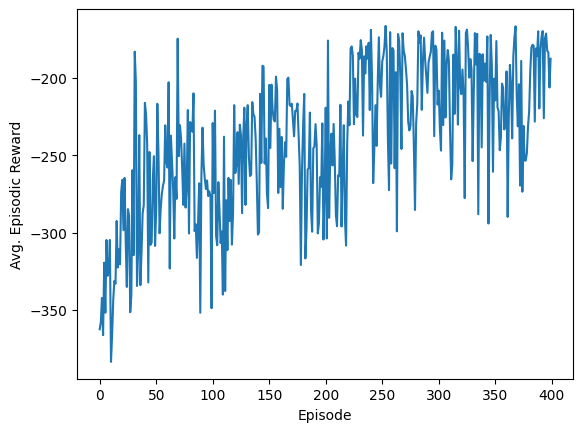

In [19]:

# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(episode_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Episodic Reward")

# Save the plot with a simplified name
plot_filename = f"{dir}{uid}_rewards.png"
plt.savefig(plot_filename)

### QBERs plot

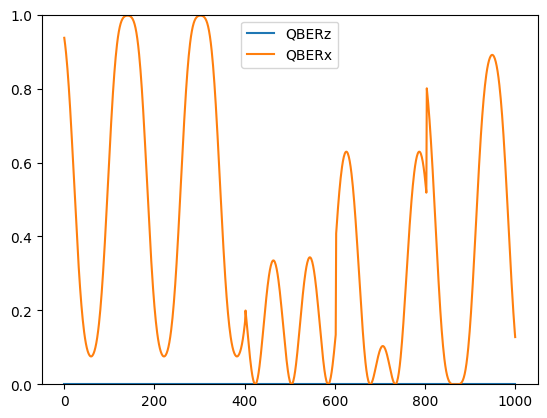

In [20]:
fig = plt.figure()
plt.ylim(0, 1)
plt.plot(env.qber_history)
plt.legend(["QBERz", "QBERx"])

# Save the plot with a simplified name
plot_filename = f"{dir}{uid}_QBER.png"
plt.savefig(plot_filename)

# Best agent

Best agent is from ep.:  253


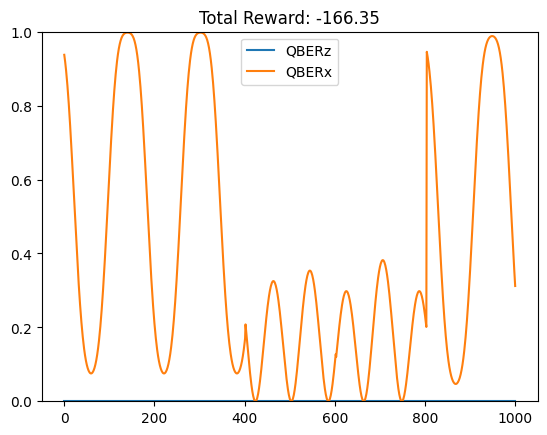

In [21]:
print("Best agent is from ep.: ", best_result['episode'])

fig = plt.figure()
plt.title(f"Total Reward: {best_result['total_rewards']:.2f}")
plt.ylim(0, 1)
plt.plot(best_result['qber'])
plt.legend(["QBERz", "QBERx"])